In [1]:
import numpy as np
import pymongo
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"


# Identification de l'interface MLflow
mlflow.set_tracking_uri("file:///C:/Users/Utilisateur/Documents/GitHub/Brief 12/MovieWise_Recommender_System/mlruns")
# Identification du nom du projet MLflow
mlflow.set_experiment("kevin")

<Experiment: artifact_location=('file:///C:/Users/Utilisateur/Documents/GitHub/Brief '
 '12/MovieWise_Recommender_System/mlruns/291067862692002196'), creation_time=1707837899937, experiment_id='291067862692002196', last_update_time=1707837899937, lifecycle_stage='active', name='kevin', tags={}>

In [2]:
client = pymongo.MongoClient('localhost:27017')

db = client['movie']

movies = db['movie_json']
users = db['user_json']

In [3]:
distinct_genres = movies.aggregate([
    {
        "$project": {
            "genres": {"$split": ["$genres", "|"]}
        }
    },{
        "$unwind": "$genres"
    },
    {
        "$group": {
            "_id": "$genres",
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {
            "count": -1
        }
    }
])

[genre for genre in distinct_genres]

[{'_id': 'Drama', 'count': 1603},
 {'_id': 'Comedy', 'count': 1200},
 {'_id': 'Action', 'count': 503},
 {'_id': 'Thriller', 'count': 492},
 {'_id': 'Romance', 'count': 471},
 {'_id': 'Horror', 'count': 343},
 {'_id': 'Adventure', 'count': 283},
 {'_id': 'Sci-Fi', 'count': 276},
 {'_id': "Children's", 'count': 251},
 {'_id': 'Crime', 'count': 211},
 {'_id': 'War', 'count': 143},
 {'_id': 'Documentary', 'count': 127},
 {'_id': 'Musical', 'count': 114},
 {'_id': 'Mystery', 'count': 106},
 {'_id': 'Animation', 'count': 104},
 {'_id': 'Western', 'count': 68},
 {'_id': 'Fantasy', 'count': 68},
 {'_id': 'Film-Noir', 'count': 44}]

In [4]:
desired_genres = ['Children', 'Horror']
filtered_movies = movies.find({"genres": {"$regex": f".*{'|'.join(desired_genres)}.*"}})

In [5]:
list(filtered_movies)

[{'_id': 1,
  'title': 'Toy Story (1995)',
  'genres': "Animation|Children's|Comedy"},
 {'_id': 2,
  'title': 'Jumanji (1995)',
  'genres': "Adventure|Children's|Fantasy"},
 {'_id': 8, 'title': 'Tom and Huck (1995)', 'genres': "Adventure|Children's"},
 {'_id': 12,
  'title': 'Dracula: Dead and Loving It (1995)',
  'genres': 'Comedy|Horror'},
 {'_id': 13, 'title': 'Balto (1995)', 'genres': "Animation|Children's"},
 {'_id': 34, 'title': 'Babe (1995)', 'genres': "Children's|Comedy|Drama"},
 {'_id': 48,
  'title': 'Pocahontas (1995)',
  'genres': "Animation|Children's|Musical|Romance"},
 {'_id': 54, 'title': 'Big Green, The (1995)', 'genres': "Children's|Comedy"},
 {'_id': 56,
  'title': 'Kids of the Round Table (1995)',
  'genres': "Adventure|Children's|Fantasy"},
 {'_id': 60,
  'title': 'Indian in the Cupboard, The (1995)',
  'genres': "Adventure|Children's|Fantasy"},
 {'_id': 70,
  'title': 'From Dusk Till Dawn (1996)',
  'genres': 'Action|Comedy|Crime|Horror|Thriller'},
 {'_id': 87,
  

In [6]:
movies_ids = movies.find({'genres': {'$regex': 'Children|Horror'}}).distinct('_id')
users_ids = users.distinct('_id')

In [7]:
df = pd.DataFrame(0, index=users_ids, columns=movies_ids)
df

,1,2,8,12,13,34,48,54,56,60,...,3931,3932,3933,3935,3938,3939,3940,3941,3942,3945
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
films = ['film1', 'film2', 'film3']

In [9]:
idx = 0
for f in films:
    print(idx, f)
    idx += 1

0 film1
1 film2
2 film3


In [10]:
for idx, f in enumerate(films):
    print(idx, f)

0 film1
1 film2
2 film3


In [11]:
for u_id in users_ids:
    user = users.find_one({'_id': u_id})

    for m in user['movies']:
        
        m_id = m['movieid']
        rating = m['rating']

        if m_id in movies_ids:
            df.loc[u_id, m_id] = rating

In [12]:
df

,1,2,8,12,13,34,48,54,56,60,...,3931,3932,3933,3935,3938,3939,3940,3941,3942,3945
1,5,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6039,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df = df[df.sum(axis=1) > 0]
df

,1,2,8,12,13,34,48,54,56,60,...,3931,3932,3933,3935,3938,3939,3940,3941,3942,3945
1,5,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6039,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_sparse = df.astype(pd.SparseDtype("float", 0))

In [15]:
with mlflow.start_run() as run:
    n_components = 2
    max_iter = 2000
    nmf = NMF(n_components=n_components, max_iter=max_iter)

    # Fit the model to the user-item matrix
    nmf.fit(df_sparse)

    U = nmf.transform(df_sparse)  # User matrix
    M = nmf.components_  # Item matrix

    pred_matrix = np.dot(U, M)

    MSE = mean_squared_error(df_sparse.values, pred_matrix)

    mlflow.log_params({"n_components": n_components})
    mlflow.log_params({"max_iter": max_iter})

    mlflow.log_metric("MSE", MSE)

print(MSE)

0.35627635108319783


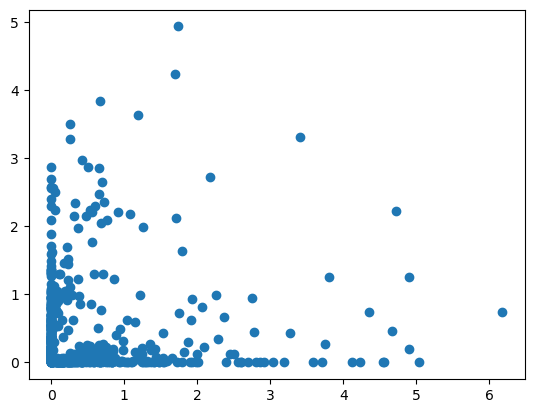

In [16]:
plt.scatter(M[0, :], M[1, :])